# Low-Depth Quantum Circuits using a Separable Pair Approximation

In [1]:
# needs version >= 1.5
import tequila as tq
import numpy
import matplotlib.pyplot as plt

This notebook illustrates some examples for the separable pair ansatz (SPA) following [arxiv:2105.03836](https://arxiv.org/abs/2105.03836).  

As in the article, we will use a combination with the basis-set-free VQE from [arxiv:2008.02819](https://arxiv.org/pdf/2008.02819.pdf).

Feel free to contact [me](mailto:jakob.kottmann@utoronto.ca) if you have questions :-) 

### Dependencies
Here are some instructions, you need to follow if you want to compute your own basis-set-free Hamiltonians with madness. You however don't need to install it and can just use the provided pre-computed Hamiltonians.
The necessary data for all molecules of this notebook (and some more) is provided (`.npy` and `pnoinfo.txt` files in `data/basis-set-free-molecules/`), in order to read the data in, set `npno=None` in the cell below and of course, make sure to have the [data](https://github.com/aspuru-guzik-group/tequila-tutorials/tree/main/data/basis-set-free-molecules) available on your system.

If you want to compute your own Hamiltonians, tequila needs a special [fork](https://github.com/kottmanj/madness) of madness compiled - instruction on compilation can be found by following the link. Note, that Windows is not supported as an OS. See also the corresponding [tutorial](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/ChemistryMadnessInterface.ipynb) on the madness interface.

In order for tequila to find the madness backend, the directory where madness was compiled needs to be exported to the environment variable `MAD_ROOT_DIR`. In the cell below this is illustrated for this notebook. Of course, the path needs to be adapted depending where you have installed madness. If you plan to read the data from the provided files, just ignore the next cell. See the `madness_interface` tutorial for more information.

In [2]:
import os
os.environ['MAD_ROOT_DIR'] = "/home/jsk/devel/madness/build-opt" # needs to be adapted

#if set to None we will read data from files. Make sure those files are there (in data/basis-set-free-molecules/)
#set n_pno=2 (or other value) in order to compute with madness as backend (will delete old files)
n_pno=None

#if data is not read in it is recommended to switch the directory in order to not overwrite files
datadir="data/basis-set-free-molecules"

## Example1: BeH$_2$ near equilibrium

We will start with a simple calculation of the BeH$_2$ molecule. This molecule has 6 electrons.
By default the `frozen_core` approximation is activated, this means that 2 of the 6 electrons are neglected in the correlated treatment.
The two electrons are the core-electrons of the Be atom (the occupied Hartree-Fock orbital with the lowest energy). So we will end up with 4 electrons in 2+`n_pno` spatial orbitals.
In this notebook we have `n_pno=2` which leads to 4 electrons in 4 spatial orbitals (8 qubits/spin-orbitals) i.e. BeH$_2$(4,8).

In [3]:
geometry="Be 0.0 0.0 0.0\nH 0.0 0.0 {R}\nH 0.0 0.0 -{R}"
name=datadir+"/beh2_{R}"

In [4]:
R=1.5
mol = tq.Molecule(name=name.format(R=R), geometry=geometry.format(R=R), n_pno=n_pno)

We can print the molecule, in order to obtain some more information about it. Note that orbital 0 is missing (due to `frozen_core=True` which is the default but can be deactivated by passing the keyword to `tq.Molecule`).

In [5]:
print(mol)

<class 'tequila.quantumchemistry.madness_interface.QuantumChemistryMadness'>
Qubit Encoding
JordanWigner

Parameters
basis_set       : custom          
geometry        : Be 0.0 0.0 0.0
H 0.0 0.0 1.5
H 0.0 0.0 -1.5 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : data/basis-set-free-molecules/beh2_1.5 

MRA Orbitals    :
orbital 1, occupied reference orbital (1,), energy -0.451953 
orbital 2, occupied reference orbital (2,), energy -0.451953 
orbital 3, pno from pair (1, 1), MP2 occ 0.00920606 
orbital 4, pno from pair (2, 2), MP2 occ 0.00920605 

executable      : /home/jsk/devel/madness/build-opt/src/apps/pno/pno_integrals
htensor         : data/basis-set-free-molecules/beh2_1.5_htensor.npy
gtensor         : data/basis-set-free-molecules/beh2_1.5_gtensor.npy



Let's compute some energies (two classical methods: MP2, CCSD and two VQE methods: SPA and UpCCGSD)

E(MP2) = -15.7783424618309  E_corr = -0.0191803844502508
E(CCSD) = -15.78941228695859  E_corr = -0.03025020957798473


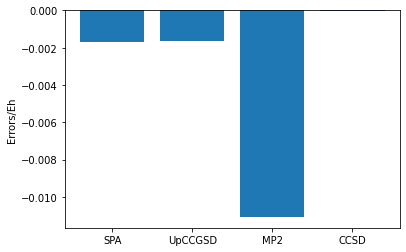

In [6]:
errors = {}
reference = mol.compute_energy("fci")
for method in ["SPA", "UpCCGSD", "MP2", "CCSD"]:
    errors[method] = reference-mol.compute_energy(method, silent=True)

plt.bar(list(errors.keys()), list(errors.values()))
plt.ylabel("Errors/Eh")
plt.show()

## Example2: Stretched BeH$_2$  

For the second example we use the same molecule, but a more challenging structure. In the following we will construct the SPA circuit and combine it with a layer of (approximate) generalized singles rotations.  

First we construct the molecule and compute some reference values (same procedure as before)

In [7]:
R=4.5
mol2 = tq.Molecule(name=name.format(R=R), geometry=geometry.format(R=R), n_pno=n_pno)

In [8]:
errors2={}
fci2 = mol2.compute_energy("fci")
errors2["MP2"]=fci2 - mol2.compute_energy("MP2")

E(MP2) = -15.6166747605039  E_corr = -0.290106192723903


Now we construct the SPA ansatz and get the qubit Hamiltonian from the molecule. Later this will be combined to expectation values that can be optimized.  

See the Chemistry, BasicUsage and Optimizer tutorials of tequila for more information about the individual components.

In [9]:
U = mol2.make_upccgsd_ansatz(name="spa")
H = mol2.make_hamiltonian()

Let's see how the SPA circuit looks like in this case. Wee will use the local\_qubit\_map to see the pair strucutre of the circuit. Note that you can transform the Hamiltonian in the same way if you want to use this qubit mapping. The local qubit map groups the orbitals of the separable electron pairs together ( pair $x$ has Hartree-Fock orbital $x$ and all PNOs of MP2 pair $(x,x)$. 

In [10]:
# not necessary to use the map, but will give more overview in circuit plots
# the map sorts the orbitals by their respective pairs (naturally they are sorted by their occupation numbers in the MP2-MRA-PNO surrogate model)
qm = mol2.local_qubit_map()
tq.circuit.export_to(U.map_qubits(qm), filename="pics/beh2_spa.png")

This is the circuit that was drawn by the code above:
<img src="pics/beh2_spa.png" alt="SPA Circuit" width="200"/>

In the second circuit we take the SPA circuit and add a further layer of generalized approximate singles to it. The apprioximation corresponds to neglecting all $Z$ terms in the Jordan-Wigner strings of the excitation operators that generate the corresponding gates. The approximation is triggered by the "A" in the name and will only work for Jordan-Wigner encoding.

Further down we construct a similar circuit using standard single excitations.

In [11]:
U2 = U + mol2.make_upccgsd_ansatz(name="GAS", include_reference=False)

In [12]:
tq.circuit.export_to(U2.map_qubits(qm), filename="pics/beh2_spa+gas.png")

<img src="pics/beh2_spa+gas.png" alt="drawing" width="500"/>

Now we optimize the expectation values resulting from the different circuits. Note that the standard initialization (all variables to 0.0) will result in faulty convergence for the signles layer, so we let the initial values deviate a bit).

In [13]:
# SPA optimization
E = tq.ExpectationValue(H=H, U=U)
result = tq.minimize(E, print_level=2)
errors2["SPA"]=fci2-result.energy

# perturbation for starting points (starting singles in 0.0 usually is already a local minimum)
x = numpy.pi/4

# SPA+GAS optimization (approximated singles rotations)
E2 = tq.ExpectationValue(H=H, U=U2)
ival={**{k:numpy.random.normal(scale=x,loc=0.0) for k in E2.extract_variables()}, **result.variables}
result2 = tq.minimize(E2, initial_values=ival, print_level=2)
errors2["SPA+GAS"]=fci2-result2.energy

# SPA+S optimization
# enforce more symmetry by not approximating singles
# spin-adaption will be turned on by default
U3 = U + mol2.make_upccgsd_ansatz(name="S", include_reference=False)
E3 = tq.ExpectationValue(H=H, U=U3)
ival={**{k:numpy.random.normal(scale=x,loc=0.0) for k in E3.extract_variables()}, **result.variables}
result3 = tq.minimize(E3, initial_values=ival, print_level=2)
errors2["SPA+S"]=fci2-result3.energy

# SPA+GS optimization
# the same with generalized singles
U4 = U + mol2.make_upccgsd_ansatz(name="GS", include_reference=False)
E4 = tq.ExpectationValue(H=H, U=U4)
ival={**{k:numpy.random.normal(scale=x,loc=0.0) for k in E4.extract_variables()}, **result.variables}
result4 = tq.minimize(E4, initial_values=ival, print_level=2)
errors2["SPA+GS"]=fci2-result4.energy

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 4 expectationvalues

active variables : 2

E=-15.32656857
E=-15.34381382
E=-15.36510721
E=-15.36609255
Optimization terminated successfully.
         Current function value: -15.366093
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 28 expectationvalues

active variables : 14

E=-15.17366403
E=-15.24613408
E=-15.36181899
E=-15.40156802
E=-15.40732876
E=-15.41265069
E=-15.41630052
E=-15.41754111
E=-15.41831749
E=-15.41

This is what we get:  
Adding the singles layer can improve the result significantly. This is what is demonstrated in the article on LiH and C$_2$H$_6$ in more detail. 
On first glance it doesn't seem to make a huge difference if the singles are approximated or not.

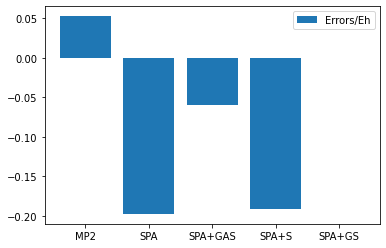

In [14]:
plt.figure()
plt.bar(list(errors2.keys()), list(errors2.values()), label="Errors/Eh")
plt.legend()
plt.show()

Since we are dealing with a 8 qubit model here, we can diagonalize the corresponding Hamiltonian exactly without much trouble. If we do so, we discover, that for this instance, the groundstate is a triplet, and the targeted singlet groundstate is slightly higher in energy. Note that the simple numpy diagonalization does usually not lead to the triplet in it's canonical representation, instead the spin-polarized and spin-neutral parts are mixed (this will vary each run).

Note that we are operating in a system-adapted basis that targets the singlet groundstate (this is what the madness code does) - see more in this [article](https://doi.org/10.1021/acs.jpclett.0c03410) (or [arxiv:2008.02819](https://arxiv.org/abs/2008.02819)).
Let's see how much overlap we have with this state by using either the plain Hartree-Fock wavefunction, the SPA wavefunction or it's extended versions SPA+GAS and SPA+GS. Be aware that for SPA+GAS/GS different runs might result in different outcomes due to the slightly random initialization - good initialization protocols would be great in the future :-).

In [15]:
v,vv = numpy.linalg.eigh(H.to_matrix())
UHF = mol2.prepare_reference()
UHF.n_qubits=8
hf_wfn = tq.simulate(UHF)
spa_wfn = tq.simulate(U, variables=result.variables)
spa_gas_wfn = tq.simulate(U2, variables=result2.variables)
spa_s_wfn = tq.simulate(U3, variables=result3.variables)
spa_gs_wfn = tq.simulate(U4, variables=result4.variables)
energies=[]
# 0,1,2 is a triplet, state 3 is the singlet groundstate
fidelity={"SPA+GS":[], "SPA+S":[], "SPA+GAS":[], "SPA":[], "HF":[]}
for i in range(len(v)):
    if abs(v[i]) < 1:
        break
    energies.append(v[i])
    exact_wfn = tq.QubitWaveFunction.from_array(vv[:,i])
    fidelity["SPA+GS"]  += [abs(exact_wfn.inner(spa_gs_wfn))**2]
    fidelity["SPA+GAS"] += [abs(exact_wfn.inner(spa_gas_wfn))**2]
    fidelity["HF"]      += [abs(exact_wfn.inner(hf_wfn))**2]
    fidelity["SPA"]     += [abs(exact_wfn.inner(spa_wfn))**2]
    fidelity["SPA+S"]  += [abs(exact_wfn.inner(spa_s_wfn))**2]
    if i>3:
        continue
    print("state {}, E={:+2.5f}".format(i,v[i]))
    print("fidelity(HF)     :{:+2.5f}".format(fidelity["HF"][-1]))
    print("fidelity(SPA)    :{:+2.5f}".format(fidelity["SPA"][-1]))
    print("fidelity(SPA+GAS):{:+2.5f}".format(fidelity["SPA+GAS"][-1]))
    print("fidelity(SPA+S)  :{:+2.5f}".format(fidelity["SPA+S"][-1]))
    print("fidelity(SPA+GS) :{:+2.5f}".format(fidelity["SPA+GS"][-1]))

state 0, E=-15.56382
fidelity(HF)     :+0.00000
fidelity(SPA)    :+0.00000
fidelity(SPA+GAS):+0.16755
fidelity(SPA+S)  :+0.00000
fidelity(SPA+GS) :+0.00000
state 1, E=-15.56382
fidelity(HF)     :+0.00000
fidelity(SPA)    :+0.00000
fidelity(SPA+GAS):+0.00000
fidelity(SPA+S)  :+0.00000
fidelity(SPA+GS) :+0.00000
state 2, E=-15.56382
fidelity(HF)     :+0.00000
fidelity(SPA)    :+0.00000
fidelity(SPA+GAS):+0.00000
fidelity(SPA+S)  :+0.00000
fidelity(SPA+GS) :+0.00000
state 3, E=-15.56353
fidelity(HF)     :+0.38814
fidelity(SPA)    :+0.44696
fidelity(SPA+GAS):+0.62318
fidelity(SPA+S)  :+0.36569
fidelity(SPA+GS) :+0.99993


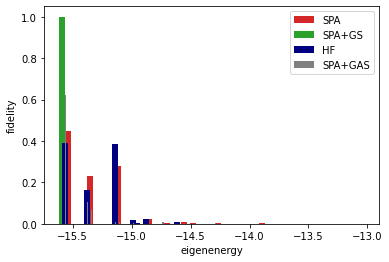

In [16]:
plt.figure()
plt.bar(energies,fidelity["SPA"], label="SPA", width=0.05, align="edge", color="tab:red")
plt.bar(energies,fidelity["SPA+GS"], label="SPA+GS", width=-0.05, align="edge", color="tab:green")
plt.bar(energies,fidelity["HF"], label="HF", width=0.05, align="center", color="navy")
plt.bar(energies,fidelity["SPA+GAS"], label="SPA+GAS", width=0.01, align="center", color="gray")
plt.ylabel("fidelity")
plt.xlabel("eigenenergy")
plt.legend()
plt.savefig("beh2_profile.pdf")
plt.show()

As in the [article](https://arxiv.org/abs/2105.03836), SPA improves upon HF for a fair price in additional gates in the preparation of the intitial state. By adding the generalized singles layer, the overlap with the singlet groundstate can ne further improved. Note, a similar result as in SPA+GS could be realized by an orbital-optimized version of SPA (see the article).

Approximating the singles (SPA+GAS) does in this case also lead to overlap with the low-lying triplet state that is nearly degenerate with the singlet groundstate. Through the approximation, the generalized singles loose their spin-adaption, SPA and SPA+GS can on the other hand not leave the singlet manifold -- note that you could switch off the spin-adaption for non-approximated singles by adding `spin_adapt_singles=False` to the construction of the GS layer or by manually construcing the circuits. Spin adaptation in this sense is just using the same variable for spin-up and spin-down orbital rotations.  

### What's next?

Some suggestions what to do with the SPA circuits introduced in this tutorial  
- Use them as initial state `Upre` in [adaptive algorithms](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/AdaptiveSolver.ipynb). Maybe: Also construct your own pools!
- Use them as initial state for your own algorithms. If the goal is a VQE: Can you improve the correlation between the pairs?  
- Try it out in combination with other algorithms (see the [article](https://arxiv.org/abs/2105.03836) for some suggestions)
- Try to implement an orbital-optimized variant of SPA (see the [article](https://arxiv.org/abs/2105.03836) for references on that)
- Compare it to other algorithms (you can for example use the Hamiltonians from this notebook)


### More Molecules without explicitly computing them?

In the [data/basis-set-free-molecules](https://github.com/aspuru-guzik-group/tequila-tutorials/tree/main/data/basis-set-free-molecules) directory, there are some more molecules provided (BeH$_2$, N$_2$ and BH$_3$ from the [article](https://arxiv.org/abs/2105.03836)). 

Here are some examples:

#### BeH$_2$(4,8)

In [17]:
have_pyscf = False
try:
    import pyscf
    have_pyscf = True
except:
    have_pyscf = False

fci={}
spa={}
hf={}
ccsd={}
n_pno = None # read data! computed with n_pno=2
for R in sorted([1.0+i*0.25 for i in range(15)] + [1.1, 1.3, 1.4]):
    mol3 = tq.Molecule(geometry="Be 0.0 0.0 0.0\nH 0.0 0.0 {R}\nH 0.0 0.0 -{R}".format(R=R), name=datadir+"/beh2_{R}".format(R=R), n_pno=None)
    spa[R] = mol3.compute_energy(method="spa", silent=True)
    if have_pyscf:
        fci[R] = mol3.compute_energy(method="fci") # needs pyscf installed
        hf[R]=mol3.compute_energy("hf") # needs pyscf installed
        ccsd[R]=mol3.compute_energy("ccsd") # needs pyscf installed

converged SCF energy = -15.6679922148016


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.hf.RHF'>


E(CCSD) = -15.69012723669342  E_corr = -0.02213503604590025
converged SCF energy = -15.7294463607983
E(CCSD) = -15.75113529861235  E_corr = -0.02168894286225017
converged SCF energy = -15.7686061773643
E(CCSD) = -15.79204467396438  E_corr = -0.0234385062695811
converged SCF energy = -15.7723514947862
E(CCSD) = -15.79687608435765  E_corr = -0.02452459417397273
converged SCF energy = -15.7702967080772
E(CCSD) = -15.79747313960713  E_corr = -0.02717644794397351
converged SCF energy = -15.7591621026432
E(CCSD) = -15.78941228695859  E_corr = -0.03025020957798473
converged SCF energy = -15.7095603221439
E(CCSD) = -15.74934650810662  E_corr = -0.03978628321087558
converged SCF energy = -15.6482279092726
E(CCSD) = -15.70004439651029  E_corr = -0.05181648801340595
converged SCF energy = -15.5867126527238
E(CCSD) = -15.6534197842735  E_corr = -0.06670713204783171
converged SCF energy = -15.5302972565422
E(CCSD) = -15.61528790851992  E_corr = -0.08499066177949531
converged SCF energy = -15.480829

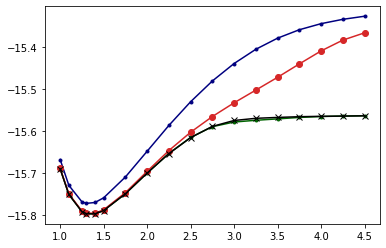

In [18]:
plt.figure()
plt.plot(list(hf.keys()), list(hf.values()), marker=".", label="HF", color="navy")
plt.plot(list(ccsd.keys()), list(ccsd.values()), marker=".", label="CCSD", color="darkgreen")
plt.plot(list(spa.keys()), list(spa.values()), marker="o", label="SPA", color="tab:red")
plt.plot(list(fci.keys()), list(fci.values()), marker="x", label="FCI", color="black")
plt.show()

#### N$_2$(6,12)

In [19]:
fci={}
spa={}
hf={}
ccsd={}
n_pno = None # read data! computed with n_pno=3
for R in sorted([0.75+i*0.25 for i in range(10)] + [0.8,0.9, 1.1, 1.2, 1.3, 1.4]):
    mol3 = tq.Molecule(geometry="N 0.0 0.0 0.0\nN 0.0 0.0 {R}".format(R=R), name=datadir+"/n2_{R}".format(R=R), n_pno=None)
    spa[R] = mol3.compute_energy(method="spa", silent=True)
    if have_pyscf:
        fci[R] = mol3.compute_energy(method="fci") # needs pyscf installed
        hf[R]=mol3.compute_energy("hf") # needs pyscf installed
        ccsd[R]=mol3.compute_energy("ccsd") # needs pyscf installed

converged SCF energy = -108.219618505039
E(CCSD) = -108.2592452736504  E_corr = -0.03962687882806944
converged SCF energy = -108.517802407507
E(CCSD) = -108.5586199859993  E_corr = -0.0408176324203082
converged SCF energy = -108.849354595195
E(CCSD) = -108.9302391959811  E_corr = -0.0808846007860704
converged SCF energy = -108.975355879149
E(CCSD) = -109.0721287262912  E_corr = -0.09677284714251284
converged SCF energy = -108.990380121489
E(CCSD) = -109.1050001796051  E_corr = -0.1146200581155742
converged SCF energy = -108.946781283974
E(CCSD) = -109.0810218850768  E_corr = -0.1342406011026258
converged SCF energy = -108.912941071501
E(CCSD) = -109.0576114367936  E_corr = -0.1446703652930684
converged SCF energy = -108.875454293809
E(CCSD) = -109.0309255596254  E_corr = -0.1554712658165696
converged SCF energy = -108.794272716089
E(CCSD) = -108.972420566356  E_corr = -0.1781478502666871
converged SCF energy = -108.710483208957
E(CCSD) = -108.9126516635462  E_corr = -0.2021684545888488

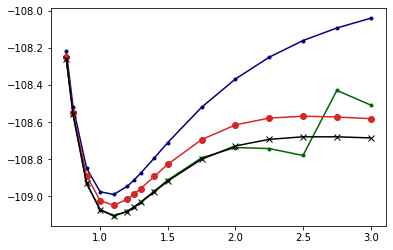

In [20]:
plt.figure()
plt.plot(list(hf.keys()), list(hf.values()), marker=".", label="HF", color="navy")
plt.plot(list(ccsd.keys()), list(ccsd.values()), marker=".", label="CCSD", color="darkgreen")
plt.plot(list(spa.keys()), list(spa.values()), marker="o", label="SPA", color="tab:red")
plt.plot(list(fci.keys()), list(fci.values()), marker="x", label="FCI", color="black")
plt.show()

In [21]:
fci={}
spa={}
hf={}
ccsd={}
n_pno=None # read data! it was computed with n_pno=1
for R in sorted([0.5 + x*0.25 for x in range(20)] + [1.4, 1.6, 1.7]):
    mol3 = tq.Molecule(n_pno=n_pno, geometry="Li 0.0 0.0 0.0\nH 0.0 0.0 {R}".format(R=R), name=datadir+"/lih_{R}".format(R=R))
    spa[R] = mol3.compute_energy(method="spa", silent=True)
    if have_pyscf:
        fci[R] = mol3.compute_energy(method="fci") # needs pyscf installed
        hf[R]=mol3.compute_energy("hf") # needs pyscf installed
        ccsd[R]=mol3.compute_energy("ccsd") # needs pyscf installed

converged SCF energy = -7.20102085961948
E(CCSD) = -7.218624946180478  E_corr = -0.01760408656285888
converged SCF energy = -7.69107721498333
E(CCSD) = -7.708444925700343  E_corr = -0.01736774138905986
converged SCF energy = -7.88831330312215
E(CCSD) = -7.904031258477795  E_corr = -0.01571795725185135
converged SCF energy = -7.96336595814755
E(CCSD) = -7.978078419113489  E_corr = -0.01471246732458815
converged SCF energy = -7.9807475475029
E(CCSD) = -7.995411657448162  E_corr = -0.01466411310233367
converged SCF energy = -7.98573080958623
E(CCSD) = -8.000624035476035  E_corr = -0.01489323647756964
converged SCF energy = -7.98718874276588
E(CCSD) = -8.002509109447631  E_corr = -0.01532041728860519
converged SCF energy = -7.98621713584729
E(CCSD) = -8.002134548569908  E_corr = -0.01591744703347765
converged SCF energy = -7.98500153292525
E(CCSD) = -8.001274108453581  E_corr = -0.01627260648202502
converged SCF energy = -7.97473522400141
E(CCSD) = -7.99319238865208  E_corr = -0.0184571776

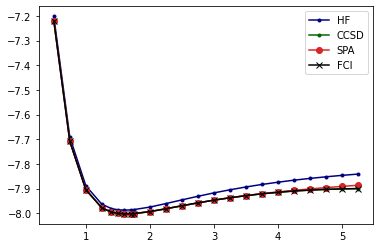

In [22]:
plt.figure()
plt.plot(list(hf.keys()), list(hf.values()), marker=".", label="HF", color="navy")
plt.plot(list(ccsd.keys()), list(ccsd.values()), marker=".", label="CCSD", color="darkgreen")
plt.plot(list(spa.keys()), list(spa.values()), marker="o", label="SPA", color="tab:red")
plt.plot(list(fci.keys()), list(fci.values()), marker="x", label="FCI", color="black")
plt.legend()
plt.show()

#### H$_2$(2,4)

In [23]:
fci={}
spa={}
hf={}
ccsd={}
n_pno = None # read data! computed with n_pno=1
for R in sorted([0.5+i*0.25 for i in range(10)] + [0.6, 0.7, 0.8, 0.9]):
    mol3 = tq.Molecule(geometry="H 0.0 0.0 0.0\nH 0.0 0.0 {R}".format(R=R), name=datadir+"/h2_{R}".format(R=R), n_pno=n_pno)
    spa[R] = mol3.compute_energy(method="spa", silent=True)
    if have_pyscf:
        fci[R] = mol3.compute_energy(method="fci") # needs pyscf installed
        hf[R]=mol3.compute_energy("hf") # needs pyscf installed
        ccsd[R]=mol3.compute_energy("ccsd") # needs pyscf installed

converged SCF energy = -1.06490592310947
E(CCSD) = -1.077562507938891  E_corr = -0.01265658482942324
converged SCF energy = -1.11639792428107
E(CCSD) = -1.131093452548504  E_corr = -0.01469552826742964
converged SCF energy = -1.13274963279915
E(CCSD) = -1.14976689395565  E_corr = -0.01701726115650304
converged SCF energy = -1.13335757683105
E(CCSD) = -1.151648306604335  E_corr = -0.0182907297732816
converged SCF energy = -1.1308207167049
E(CCSD) = -1.15046329950247  E_corr = -0.01964258279757117
converged SCF energy = -1.1192174182263
E(CCSD) = -1.141818743308879  E_corr = -0.02260132508257617
converged SCF energy = -1.1025577024318
E(CCSD) = -1.128477953913592  E_corr = -0.0259202514817888
converged SCF energy = -1.05333748712716
E(CCSD) = -1.089243434591529  E_corr = -0.03590594746437135
converged SCF energy = -1.00496702890711
E(CCSD) = -1.053578278876645  E_corr = -0.04861124996953886
converged SCF energy = -0.962386670820461
E(CCSD) = -1.026226767246037  E_corr = -0.06384009642557

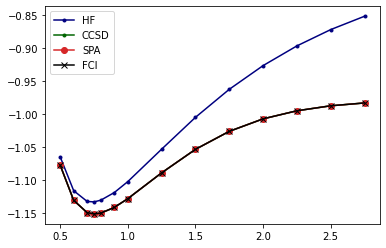

In [24]:
plt.figure()
plt.plot(list(hf.keys()), list(hf.values()), marker=".", label="HF", color="navy")
plt.plot(list(ccsd.keys()), list(ccsd.values()), marker=".", label="CCSD", color="darkgreen")
plt.plot(list(spa.keys()), list(spa.values()), marker="o", label="SPA", color="tab:red")
plt.plot(list(fci.keys()), list(fci.values()), marker="x", label="FCI", color="black")
plt.legend()
plt.show()

#### BH$_3$

In [25]:
fci={}
spa={}
hf={}
ccsd={}
n_pno = None # read data! computed with n_pno=3
for R in sorted([0.5+i*0.25 for i in range(10)] + [0.6, 0.9, 1.1]):
    mol3 = tq.Molecule(geometry=datadir+"/bh3_{}.xyz".format(R), name=datadir+"/bh3_{R}".format(R=R), n_pno=n_pno)
    spa[R] = mol3.compute_energy(method="spa", silent=True)
    if have_pyscf:
        fci[R] = mol3.compute_energy(method="fci") # needs pyscf installed
        hf[R]=mol3.compute_energy("hf") # needs pyscf installed
        ccsd[R]=mol3.compute_energy("ccsd") # needs pyscf installed

converged SCF energy = -23.6353315382324
E(CCSD) = -23.67534366226616  E_corr = -0.0400121241357447
converged SCF energy = -24.860006338728
E(CCSD) = -24.89723308867797  E_corr = -0.03722675397076936
converged SCF energy = -25.8012462834438
E(CCSD) = -25.83445078403519  E_corr = -0.03320450988325745
converged SCF energy = -26.2112858544112
E(CCSD) = -26.24294895999107  E_corr = -0.0316631075062785
converged SCF energy = -26.3347554988658
E(CCSD) = -26.3689704674294  E_corr = -0.03421497396190476
converged SCF energy = -26.3899651451976
E(CCSD) = -26.42850456114387  E_corr = -0.03853943893040206
converged SCF energy = -26.3969258467741
E(CCSD) = -26.4436192127379  E_corr = -0.04669341157847136
converged SCF energy = -26.3125420611316
E(CCSD) = -26.37691759802942  E_corr = -0.06437580862698729
converged SCF energy = -26.189553959395
E(CCSD) = -26.27613114584645  E_corr = -0.08657722252868216
converged SCF energy = -26.0682615750206
E(CCSD) = -26.18127177562996  E_corr = -0.11301021161126

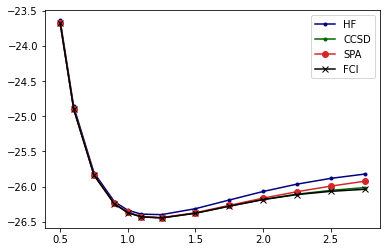

In [26]:
plt.figure()
plt.plot(list(hf.keys()), list(hf.values()), marker=".", label="HF", color="navy")
plt.plot(list(ccsd.keys()), list(ccsd.values()), marker=".", label="CCSD", color="darkgreen")
plt.plot(list(spa.keys()), list(spa.values()), marker="o", label="SPA", color="tab:red")
plt.plot(list(fci.keys()), list(fci.values()), marker="x", label="FCI", color="black")
plt.legend()
plt.show()

In [27]:
# Since it might be useful, here is one convenient way to create the BH3 coordinates over a Z-Matrix
# You will need to have psi4 installed for this
def bh3(R):
    try:
        import psi4
    except:
        raise Exception("You need psi4")
    ZM = """
    0 1
    B
    H       1        {R}
    H       1        {R}         2      120.00000
    H       1        {R}         2      120.00000     3      180.0
    """

    mol = psi4.geometry(ZM.format(R=R))
    coord = mol.save_string_xyz_file()
    with open( datadir+"/bh3_{}.xyz".format(R) , "w") as f:
        print(coord, file=f)
    